# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-03-25 14:11:20.427138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('All', 'Bona'), value='All')

# II. Load Data

In [3]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[3],description='Histogram File :',disabled=False); input_widget



Dropdown(description='Histogram File :', index=3, options=('hist2D-All-nE16-nt24-normnone.pkl', 'hist3D-All-nE…

In [4]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  82283
Number of Property Sets:  82283


In [11]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*nE16*')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-All-hist2D-All-nE16-nt24-normminmax-2D-perp30-lr75-ee5-it15…

Optimisation DBSCAN

Optimal eps value: 0.28100723178503706


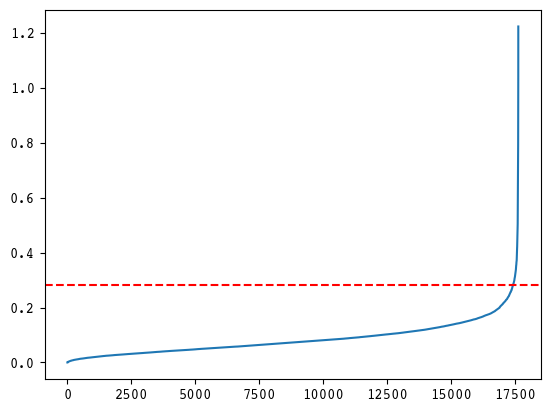

In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.neighbors import NearestNeighbors
import kneed
from kneed import KneeLocator

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties.loc[df_properties["var_prob_m"] >= 0.6]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

# min_samples = range(3,20)
# eps = np.arange(0.05,0.15, 0.01)
# output = []

# for ms in min_samples:
#     for ep in eps:
#         labels = DBSCAN(min_samples=ms, eps = ep).fit(tsne12).labels_
#         score = silhouette_score(tsne12, labels)
#         output.append((ms, ep, score))

# min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
# print(f"Best silhouette_score: {score}")
# print(f"min_samples: {min_samples}")
# print(f"eps: {eps}")


# fit a nearest neighbors model to compute the distances to k-nearest neighbors
k = 50 # choose the number of nearest neighbors to use
neighbors = NearestNeighbors(n_neighbors=k+1)
neighbors_fit = neighbors.fit(tsne12)
distances, indices = neighbors_fit.kneighbors(tsne12)

# sort the distances and plot them
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# find the knee point and use it as the optimal min_samples value
knee = kneed.KneeLocator(range(len(distances)), distances, S=1, curve='convex', direction='increasing')
min_samples = knee.elbow+1 # add 1 to convert from 0-based to 1-based indexing
eps_opt = distances[min_samples ] 

# plot the knee point on the plot
plt.axhline(eps_opt , linestyle='--', color='red')

print(f"Optimal eps value: {eps_opt}")

# show the plot
plt.show()

# # fit a nearest neighbors model to compute the distances to k-nearest neighbors
# k = 40 # choose the number of nearest neighbors to use
# nbrs = NearestNeighbors(n_neighbors=k+1).fit(tsne12)
# distances, indices = nbrs.kneighbors(tsne12)

# # compute k-distance for each point
# k_distance = distances[:,k]

# # sort the k-distances and plot them
# k_distance_sorted = np.sort(k_distance)[::-1]
# plt.plot(k_distance_sorted)

# # add axis labels and title
# plt.xlabel(f'{k}-Distance Rank')
# plt.ylabel(f'{k}-Distance')
# plt.title(f'{k}-Distance Graph')

# # show the plot
# plt.show()

# # define the range of values for min_samples and epsilon
# min_samples_range = [2,3,4,5,6]
# epsilon_range = [0.1,0.2, 0.3,0.4, 0.5]

# silhouette_scores = np.zeros((len(epsilon_range), len(min_samples_range)))
# for i, eps in enumerate(epsilon_range):
#     for j, min_samples in enumerate(min_samples_range):
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(tsne12)
#         if len(set(labels)) > 1:
#             silhouette_scores[i,j] = silhouette_score(tsne12, labels)

# # Plot the silhouette scores as a heatmap
# plt.imshow(silhouette_scores, cmap='viridis', interpolation='nearest', origin='lower')
# plt.rcParams.update({'font.size': 10})
# plt.rcParams['font.monospace'] = "Courier"
# plt.rcParams["font.family"] = "monospace"
# plt.xlabel('min_samples')
# plt.xticks(range(len(min_samples_range)), min_samples_range)
# plt.ylabel('eps')
# plt.yticks(range(len(epsilon_range )), epsilon_range )
# plt.colorbar()
# plt.show()

# # Find the combination of eps and min_samples with the highest silhouette score
# i, j = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
# best_eps = epsilon_range[i]
# best_ms = min_samples_range[j]
# print("Optimal eps:", eps)
# print("Optimal min_samples:", min_samples)


# dbscan=DBSCAN(eps=best_eps,min_samples = best_ms)
# clusters=dbscan.fit(tsne12)
# labels=clusters.labels_
# n_clusters = len(set(labels))- (1 if -1 in labels else 0)
# df_tsne_filter['cluster'] = labels
# print('Number of clusters', n_clusters)


# fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# plt.rcParams.update({'font.size': 10})
# plt.rcParams['font.monospace'] = "Courier"
# plt.rcParams["font.family"] = "monospace"
# cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], s=0.1)
# axs.set_xlabel('tSNE feature 1')
# axs.set_ylabel('tSNE feature 2')
# axs.set_title(f'high v clusters')
# unique_clusters = df_tsne_filter['cluster'].unique()
# legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
# axs.legend(cluster.legend_elements()[0], legend_labels)
# plt.show()

57
Number of clusters: 8
Number of noise points: 4423


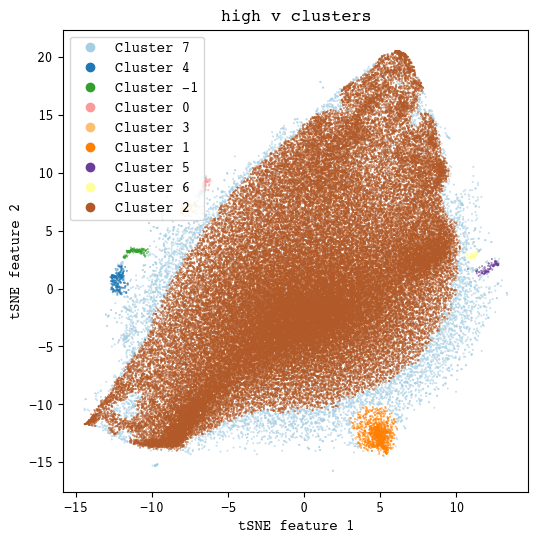

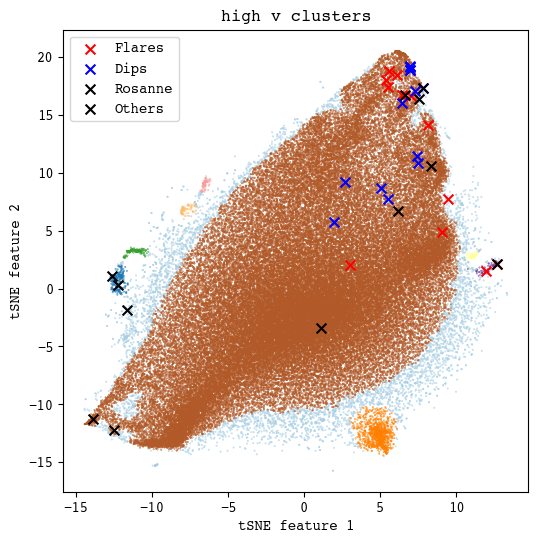

In [169]:
import hdbscan 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.6]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

#####
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
others = ['10346_11','10542_331','10542_331','10545_496','10556_5752','10556_6687','10811_223','10821_241', '1878_331','10930_1050','10953_275','10956_64']
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares)]
tsne_dips = df_tsne.loc[df_tsne['obsreg_id'].isin(dips)]
tsne_rosanne = df_tsne.loc[df_tsne['obsreg_id'].isin(rosanne)]
tsne_others = df_tsne.loc[df_tsne['obsreg_id'].isin(others)]

# Run DBSCAN
eps = 0.28
ms = 30
dbscan=DBSCAN(eps=eps,min_samples = ms)
clusters=dbscan.fit(tsne12)
labels=clusters.labels_
n_clusters = len(set(labels))- (1 if -1 in labels else 0)
df_tsne_filter['cluster'] = labels
print(n_clusters)

# # Run HDBSCAN
# min_cluster_size = 50
# min_samples = 50
# clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
# cluster_labels = clusterer.fit_predict(tsne12)
# n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# n_noise = list(cluster_labels).count(-1)
# df_tsne_filter['cluster'] = cluster_labels
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")

# Run KMeans
k_values = range(2, 30)

# # Try each value of K and calculate the silhouette score
# best_score = -1
# best_k = None
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=42)
#     kmeans.fit(tsne12)
#     score = silhouette_score(tsne12, kmeans.labels_)
#     if score > best_score:
#         best_score = score
#         best_k = k

# Use the best value of K to cluster the data
# best_k = 500
# kmeans = KMeans(n_clusters=best_k, init='k-means++', max_iter=100, random_state=42)
# cluster_labels = kmeans.fit_predict(tsne12)
# df_tsne_filter['cluster'] = cluster_labels
# n_clusters = len(set(cluster_labels))
# n_noise = list(cluster_labels).count(-1)
# print(f"Number of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")


# PLOT

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'Paired', s=0.1)
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
axs.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
axs.legend(cluster.legend_elements()[0], legend_labels)

fig, axs2 = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs2.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'Paired', s=0.1)
axs2.set_xlabel('tSNE feature 1')
axs2.set_ylabel('tSNE feature 2')
axs2.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
axs2.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='red', marker='x', s=50, label='Flares')
axs2.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=50, label='Dips')
axs2.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='black', marker='x', s=50, label='Rosanne')
axs2.scatter(tsne_others['tsne1'], tsne_others['tsne2'], c='black', marker='x', s=50, label='Others')
axs2.legend()


plt.show()




# from sklearn.cluster import DBSCAN
# from sklearn.metrics import pairwise_distances
# from sklearn.metrics import silhouette_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Compute the distance matrix for your dataset
# D = pairwise_distances(X, metric='euclidean')

# # Range of eps and min_samples values to try
# eps_range = np.arange(0.1, 1.0, 0.1)
# min_samples_range = range(5, 15)

# # Compute the silhouette score for each combination of eps and min_samples
# silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))
# for i, eps in enumerate(eps_range):
#     for j, min_samples in enumerate(min_samples_range):
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(X)
#         if len(set(labels)) > 1:
#             silhouette_scores[i,j] = silhouette_score(X, labels)

# # Plot the silhouette scores as a heatmap
# plt.imshow(silhouette_scores, cmap='hot', interpolation='nearest', origin='lower')
# plt.xlabel('min_samples')
# plt.xticks(range(len(min_samples_range)), min_samples_range)
# plt.ylabel('eps')
# plt.yticks(range(len(eps_range)), eps_range)
# plt.colorbar()
# plt.show()

# # Find the combination of eps and min_samples with the highest silhouette score
# i, j = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
# eps = eps_range[i]
# min_samples = min_samples_range[j]
# print("Optimal eps:", eps)
# print("Optimal min_samples:", min_samples)



KeyError: 'cluster'

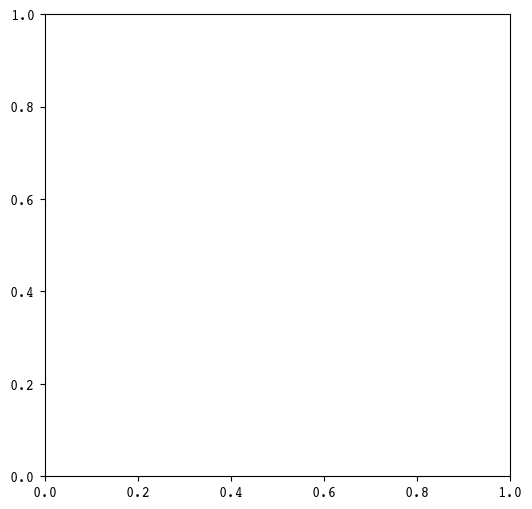

In [134]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], s=0.1)
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
axs.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
axs.legend(cluster.legend_elements()[0], legend_labels)

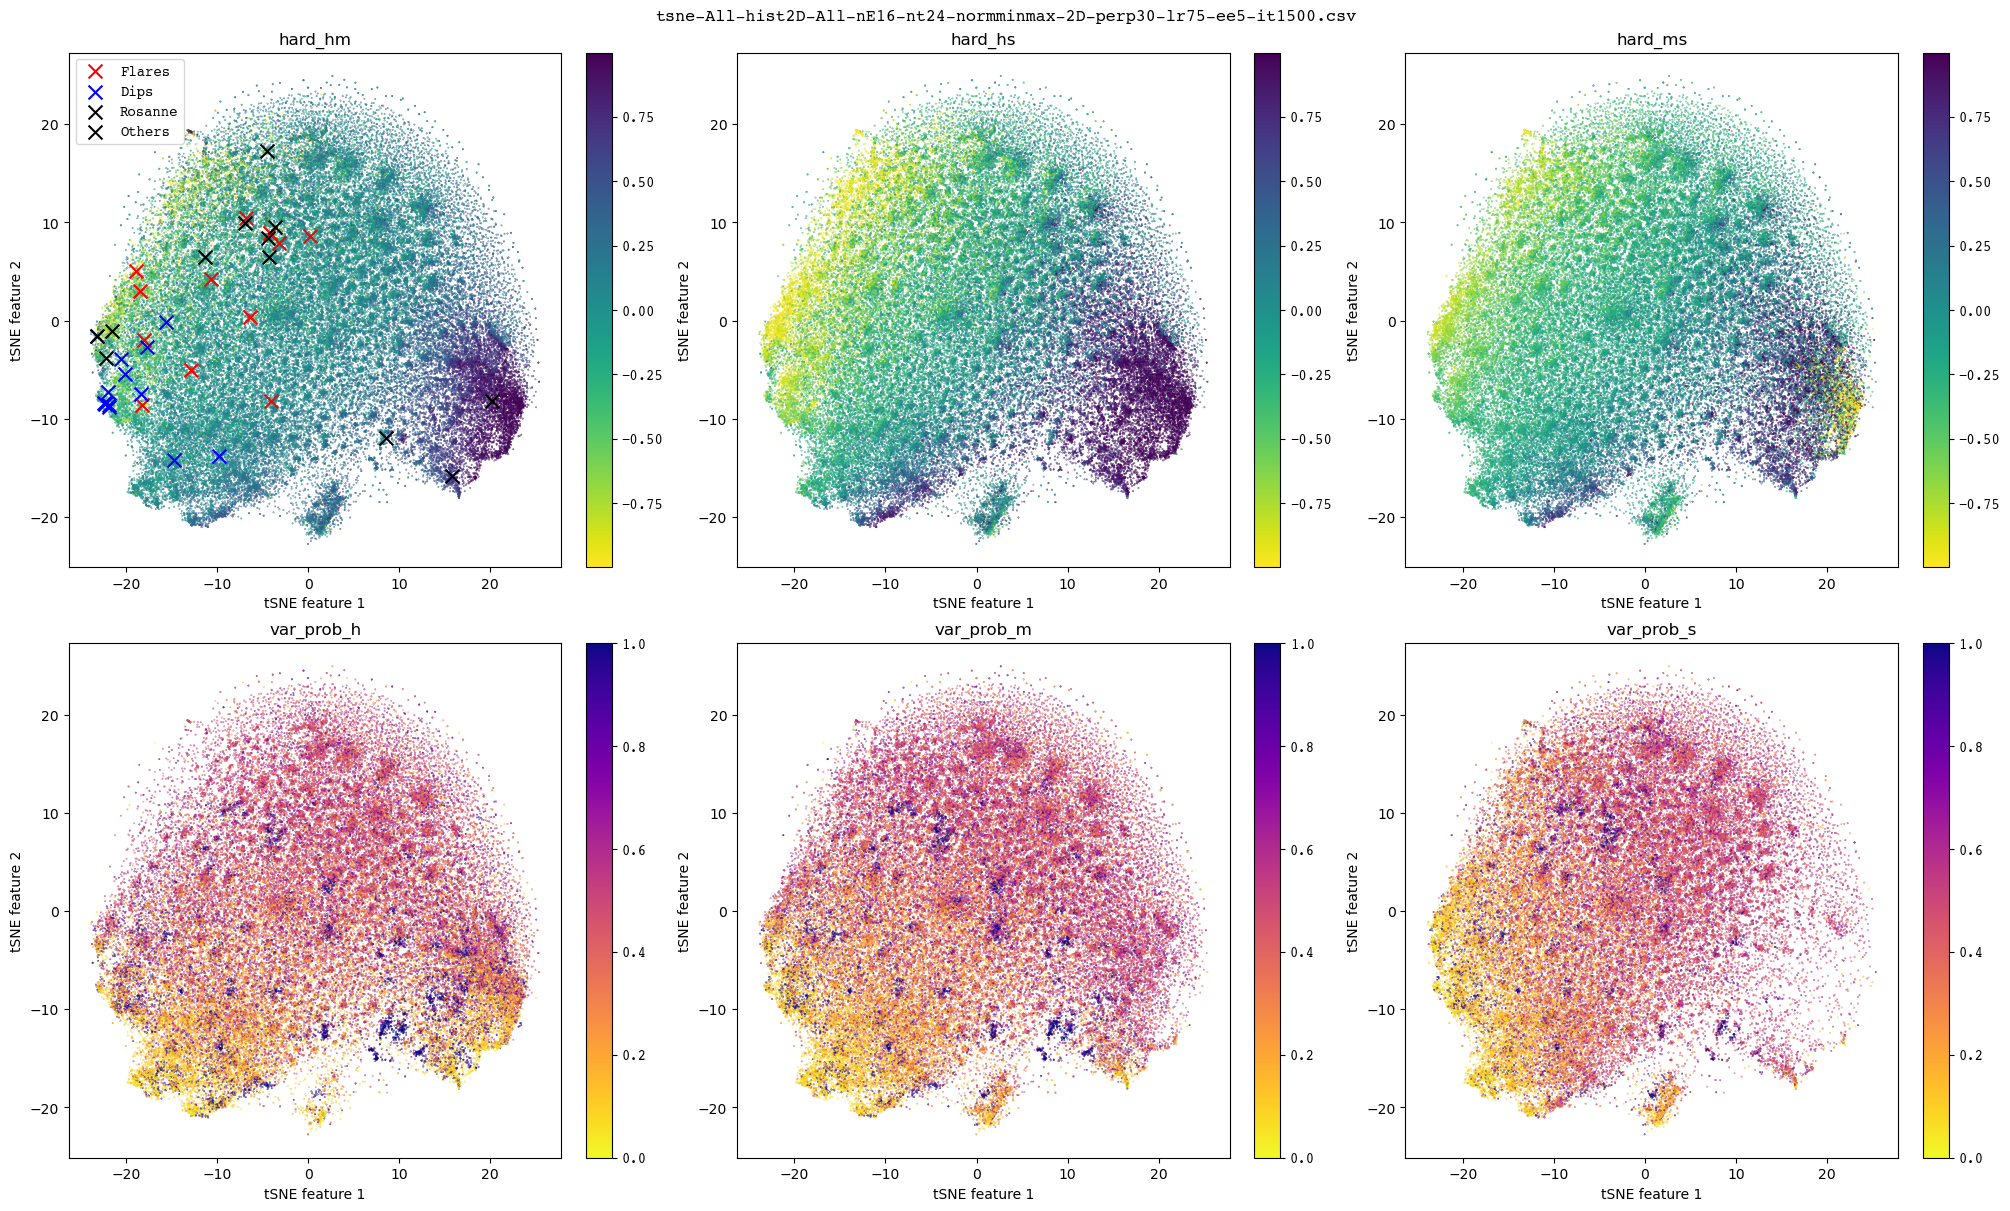

In [13]:
# Plot 2D
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
fig.suptitle(tsne_file)
colourmap_hard = 'viridis_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('tSNE feature 1')
axs[0,0].set_ylabel('tSNE feature 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('tSNE feature 1')
axs[0,1].set_ylabel('tSNE feature 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('tSNE feature 1')
axs[0,2].set_ylabel('tSNE feature 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('tSNE feature 1')
axs[1,0].set_ylabel('tSNE feature 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('tSNE feature 1')
axs[1,1].set_ylabel('tSNE feature 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('tSNE feature 1')
axs[1,2].set_ylabel('tSNE feature 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten()[0:1]:
    ax.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='black', marker='x', s=100, label='Rosanne')
    ax.scatter(tsne_others['tsne1'], tsne_others['tsne2'], c='black', marker='x', s=100, label='Others')
    ax.legend()

plt.show()